In [64]:
import numpy as np
import matplotlib.pyplot as plt

from pymoo.decomposition.asf import ASF
from auto_robot_design.description.utils import draw_joint_point
from auto_robot_design.optimization.problems import MultiCriteriaProblem
from auto_robot_design.optimization.optimizer import PymooOptimizer
from auto_robot_design.optimization.saver import load_checkpoint
from auto_robot_design.description.builder import jps_graph2pinocchio_robot

In [65]:
import tkinter as tk
from tkinter import filedialog

def select_directory():
    # Create a root window
    root = tk.Tk()
    # Hide the root window
    root.withdraw()
    # Make the root window the topmost window
    root.call('wm', 'attributes', '.', '-topmost', True)
    # Open directory dialog and store the selected directory path
    directory_path = filedialog.askdirectory(initialdir="./",
        title="Select a directory"
    )
    root.update_idletasks() 
    root.destroy()
    # Check if a directory was selected
    if directory_path:
        #print(f"Selected directory: {directory_path}")
        return directory_path
    else:
        #print("No directory selected")
        return None

# Call the function to open the directory dialog
selected_directory = select_directory()
print(f"Resulting directory path: {selected_directory}")

Resulting directory path: D:/work/projects/mechanism_builder/apps/optimize/results/first_setup/topology_2_2024-07-15_17-00-31


In [66]:
problem = MultiCriteriaProblem.load(
    selected_directory
)

checkpoint = load_checkpoint(selected_directory)
optimizer = PymooOptimizer(problem, checkpoint)
optimizer.load_history(selected_directory)
res = optimizer.run()

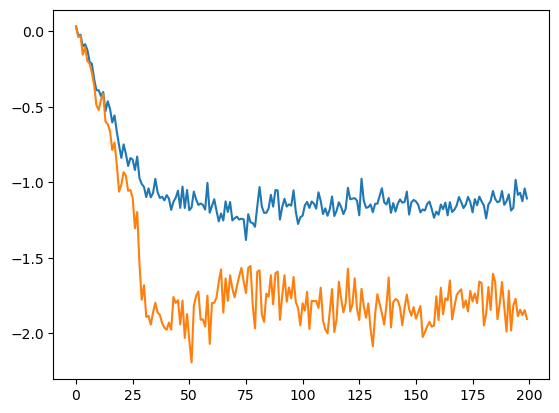

In [67]:
history_mean = optimizer.history["Mean"]
plt.plot(np.arange(len(history_mean)), history_mean)
plt.show()


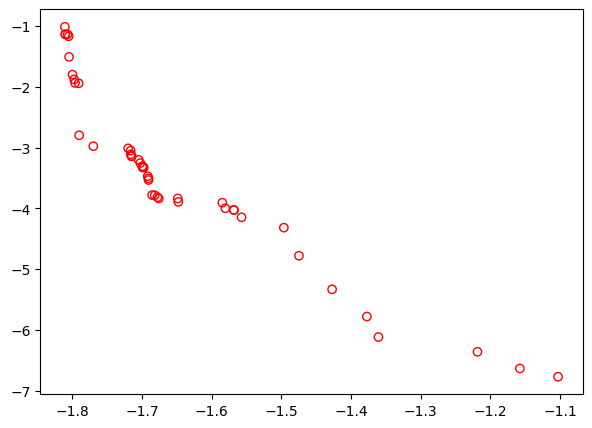

In [68]:
F = res.F
xl, xu = problem.bounds()
fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(111, )
ax.scatter(F[:, 0], F[:, 1],  facecolors='none', edgecolors='r')

In [69]:
fl = F.min(axis=0)
fu = F.max(axis=0)
print(f"Scale f1: [{fl[0]}, {fu[0]}]")
print(f"Scale f2: [{fl[1]}, {fu[1]}]")
approx_ideal = F.min(axis=0)
approx_nadir = F.max(axis=0)


Scale f1: [-1.8107305367787678, -1.1029736598332722]
Scale f2: [-6.773038384145213, -1.0123802106109083]


Best regarding ASF: 
F = [-1.47480194 -4.78112933]


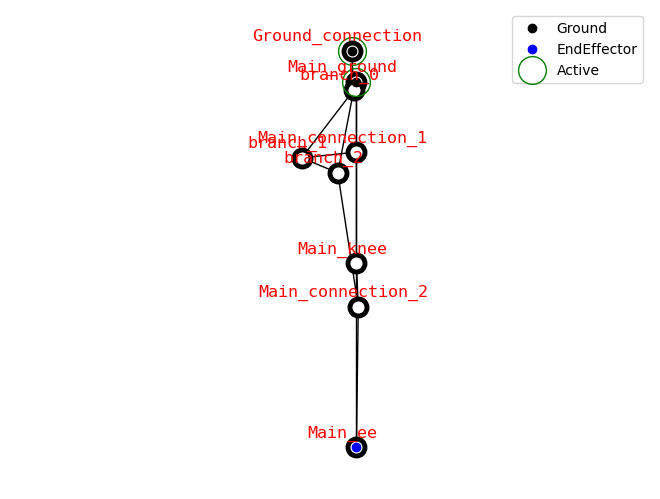

In [70]:
nF = (F - approx_ideal) / (approx_nadir - approx_ideal)
weights = np.array([0.4, 0.6])

decomp = ASF()
b = decomp.do(nF, 1/weights).argmin()
best_x = res.X[b]
print(f"Best regarding ASF: \nF = {F[b]}")
graph = problem.graph_manager.get_graph(best_x)
draw_joint_point(graph)

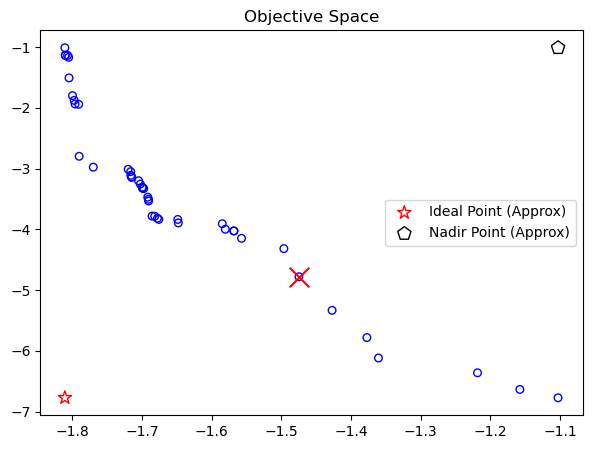

In [71]:
plt.figure(figsize=(7, 5))
plt.scatter(F[:, 0], F[:, 1], s=30, facecolors='none', edgecolors='blue')
plt.scatter(approx_ideal[0], approx_ideal[1], facecolors='none', edgecolors='red', marker="*", s=100, label="Ideal Point (Approx)")
plt.scatter(approx_nadir[0], approx_nadir[1], facecolors='none', edgecolors='black', marker="p", s=100, label="Nadir Point (Approx)")
plt.scatter(F[b, 0], F[b, 1], marker="x", color="red", s=200)
plt.title("Objective Space")
plt.legend()
plt.show()

In [72]:
histF = np.array(optimizer.history["F"])
validF1 = histF[:,0][histF[:,0]<0]
validF2 = histF[:,1][histF[:,1]<0]
print('Percentage of valid mechanisms:', len(validF1)/len(histF))

Percentage of valid mechanisms: 0.73296875


In [73]:
worstF1_id = np.argmax(validF1)
worstF2_id = np.argmax(validF2)
worst_reward2 = validF2[worstF2_id]
worst_reward1 = validF1[worstF1_id]
print('The maximum result in optimization task:', worst_reward1, worst_reward2)

The maximum result in optimization task: -0.7563176353772482 -0.3346970713640068


In [74]:
bestF1_id = np.argmin(validF1)
bestF2_id = np.argmin(validF2)
bestF1_x = optimizer.history["X"][np.where(histF[:,0]==validF1[bestF1_id])[0][0]]
bestF1_reward = validF1[bestF1_id]
bestF2_x = optimizer.history["X"][np.where(histF[:,1]==validF2[bestF2_id])[0][0]]
bestF2_reward = validF2[bestF2_id]
print("The minimum result in optimization task: F1:", bestF1_reward, " F2: ", bestF2_reward, f" F: weights: {weights}", F[b])

The minimum result in optimization task: F1: -1.8107305367787678  F2:  -6.773038384145213  F: weights: [0.4 0.6] [-1.47480194 -4.78112933]


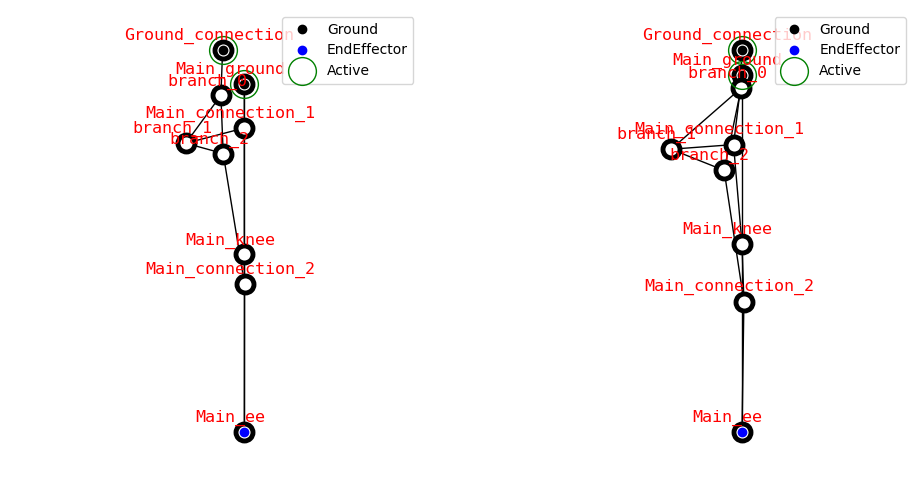

In [75]:
gm = problem.graph_manager
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
graph = gm.get_graph(bestF1_x)
draw_joint_point(graph)
plt.subplot(1, 3, 2)
graph = gm.get_graph(bestF2_x)
draw_joint_point(graph)


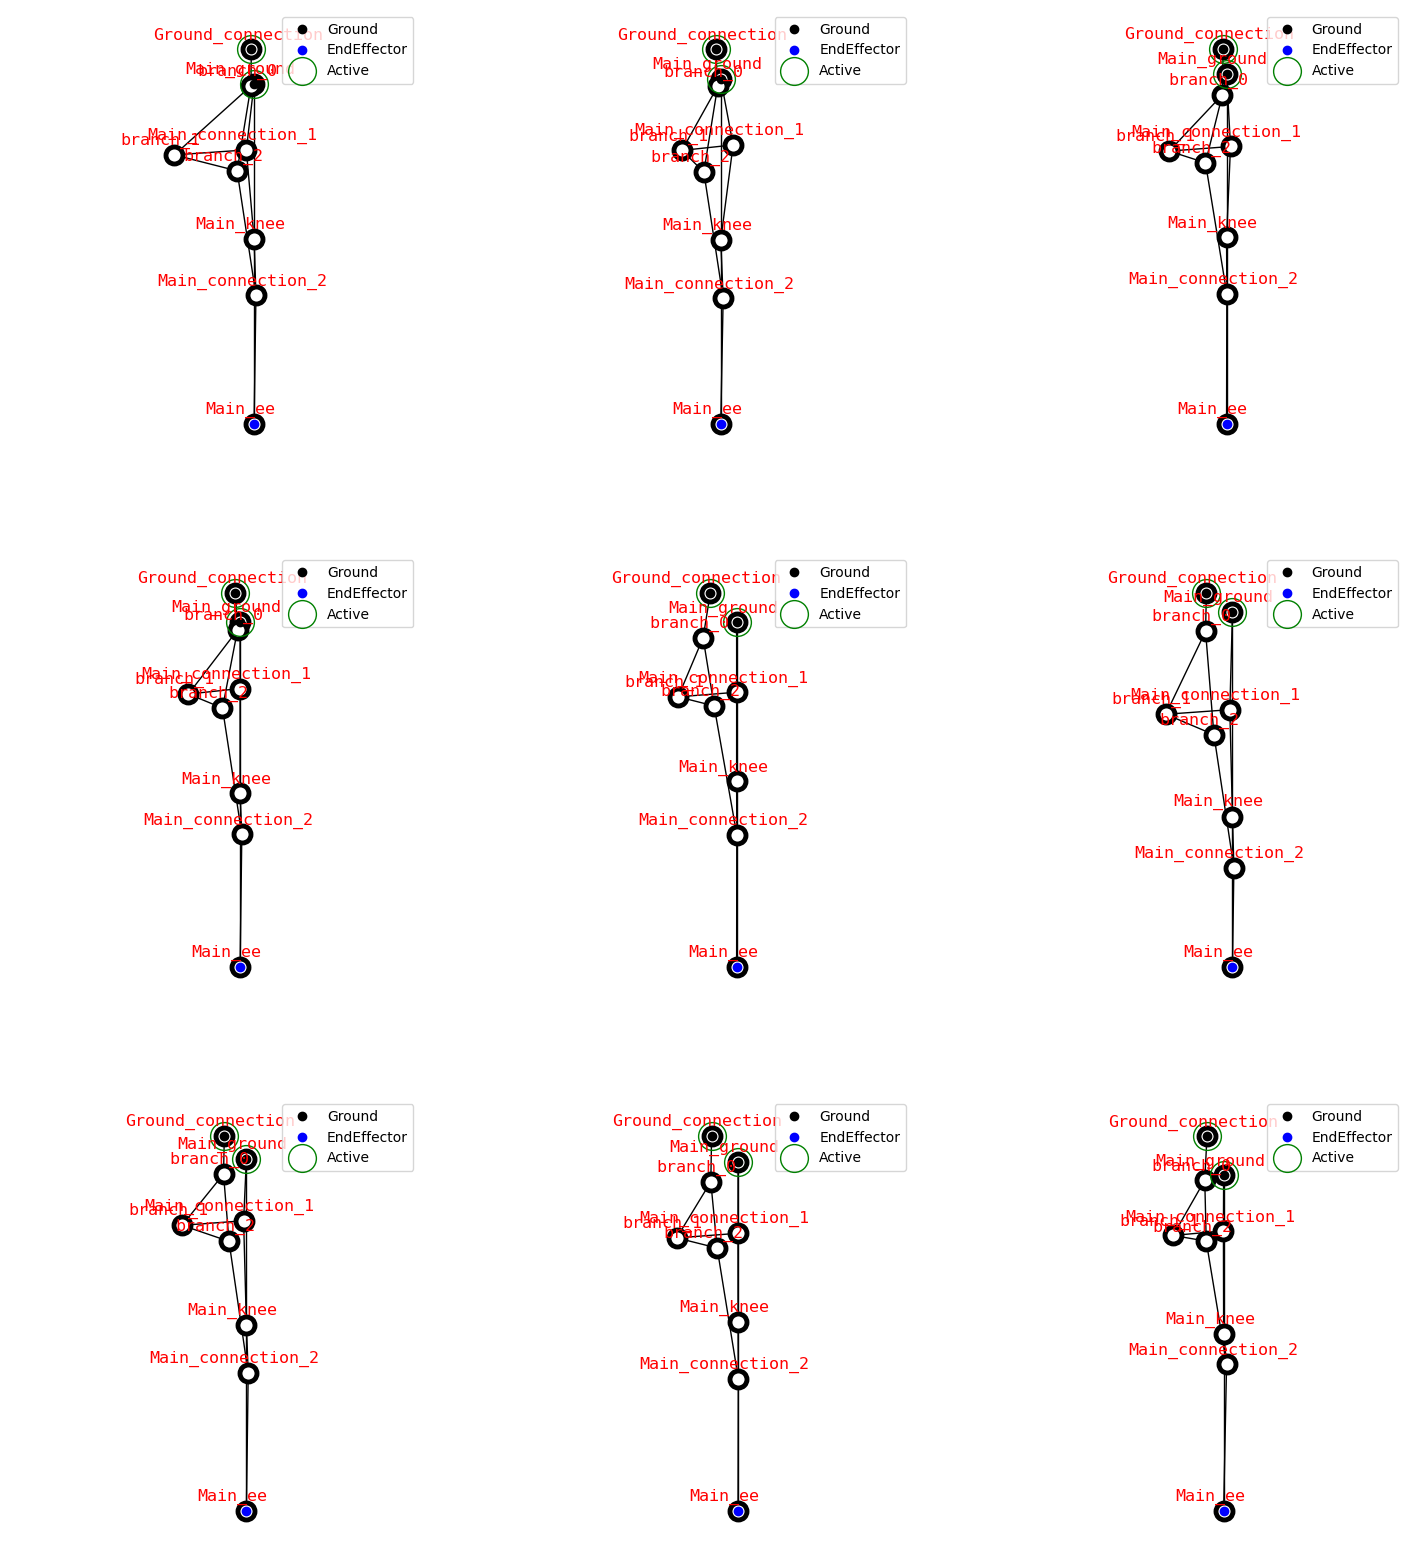

In [76]:
nF = (F - approx_ideal) / (approx_nadir - approx_ideal)
decomp = ASF()
weights_vector = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
plt.figure(figsize=(18, 20))
for i, w in enumerate(weights_vector):
    weights = np.array([w, 1-w])
    b = decomp.do(nF, 1/weights).argmin()
    best_x = res.X[b]
    graph = problem.graph_manager.get_graph(best_x)
    plt.subplot(3, 3, i+1)
    draw_joint_point(graph)

plt.show()

In [77]:
histF = res.F
validF1 = histF[:,0][histF[:,0]<0]
validF2 = histF[:,1][histF[:,1]<0]
print('Percentage of valid mechanisms:', len(validF1)/len(histF))

Percentage of valid mechanisms: 1.0


In [78]:
res.F

array([[-1.15778601, -6.63560134],
       [-1.36073887, -6.11847586],
       [-1.21858509, -6.36192397],
       [-1.55720194, -4.14828086],
       [-1.37734838, -5.78148243],
       [-1.10297366, -6.77303838],
       [-1.47480194, -4.78112933],
       [-1.71629425, -3.0508146 ],
       [-1.69942919, -3.3072336 ],
       [-1.56797564, -4.02787518],
       [-1.79024804, -2.7985732 ],
       [-1.64871788, -3.83803906],
       [-1.69756365, -3.32979921],
       [-1.67785696, -3.81858155],
       [-1.58051984, -3.99903172],
       [-1.56843781, -4.02585778],
       [-1.80529149, -1.16940793],
       [-1.67594071, -3.83716374],
       [-1.690648  , -3.53448232],
       [-1.81009038, -1.13663665],
       [-1.81073054, -1.01238021],
       [-1.71992056, -3.01317067],
       [-1.49648333, -4.3184453 ],
       [-1.42723735, -5.3339288 ],
       [-1.71482535, -3.1464711 ],
       [-1.64795371, -3.89490113],
       [-1.79738506, -1.87843814],
       [-1.79978955, -1.80012172],
       [-1.7908982 ,

In [85]:
sf = problem.soft_constrain
builder = problem.builder
crag = problem.rewards_and_trajectories.crag
trajectory = problem.rewards_and_trajectories.trajectories[1]
counter = 0
for i, x in enumerate(res.X):
    x= np.round(x, 5)
    graph = gm.get_graph(x)
    fixed_robot, free_robot = jps_graph2pinocchio_robot(graph, builder=builder)
    #point_criteria_vector, trajectory_criteria, res_dict_fixed = crag.get_criteria_data(fixed_robot, free_robot, trajectory)
    
    constrain_error, results = sf.calculate_constrain_error(crag, fixed_robot, free_robot)

    if constrain_error>0:
        print(constrain_error)
        counter+=1
    #else:
    __, partial_rewards, vector_rewards = problem.rewards_and_trajectories.calculate_total(fixed_robot, free_robot, problem.motor)
    print(res.F[i], vector_rewards)
counter

[-1.15778601 -6.63560134] [1.1567614674568176, 5.86338308800948]
[-1.36073887 -6.11847586] [1.3607388734817505, 6.118475861571068]
0.023293744423547997


ValueError: All points should be reachable to calculate a reward [0.02329324]

In [ ]:
F = np.array(optimizer.history["F"])
X = np.array(optimizer.history["X"])
Fs = np.array(optimizer.history["Fs"])
np.where(F[:,0]==res.F[0][0])

(array([8684], dtype=int64),)

In [ ]:
X[7387]

array([-0.00169,  0.03419, -0.23649, -0.06759,  0.09053, -0.01011,
        0.19403, -0.00161, -0.05193, -0.05909, -0.00788, -0.02252,
        0.14631])

In [ ]:
Fs[7387]

array([1.08460665, 1.66659057, 1.12932706, 1.5555449 , 1.99431692,
       4.31190885])

In [81]:
x = np.round(X[7387],5)
print(x)
graph = gm.get_graph(x)
fixed_robot, free_robot = jps_graph2pinocchio_robot(graph, builder=builder)
#point_criteria_vector, trajectory_criteria, res_dict_fixed = crag.get_criteria_data(fixed_robot, free_robot, trajectory)

constrain_error, results = sf.calculate_constrain_error(crag, fixed_robot, free_robot)

if constrain_error>0:
    print(constrain_error)
    counter+=1
#else:
__, partial_rewards, vector_rewards = problem.rewards_and_trajectories.calculate_total(fixed_robot, free_robot, problem.motor)
print(res.F[0], vector_rewards, '\n', partial_rewards)

[-0.00169  0.03419 -0.23649 -0.06759  0.09053 -0.01011  0.19403 -0.00161
 -0.05193 -0.05909 -0.00788 -0.02252  0.14631]
[-1.15778601 -6.63560134] [1.3533165454864502, 3.120143327495695] 
 [1.2643586, 1.6665939, 1.1289971, 3.0542013454367747, 1.9943201641112438, 4.311908472939066]


In [ ]:
for i in range(3,8):    
    x = np.round(X[7387],i)
    graph = gm.get_graph(x)
    fixed_robot, free_robot = jps_graph2pinocchio_robot(graph, builder=builder)
    #point_criteria_vector, trajectory_criteria, res_dict_fixed = crag.get_criteria_data(fixed_robot, free_robot, trajectory)

    constrain_error, results = sf.calculate_constrain_error(crag, fixed_robot, free_robot)

    if constrain_error>0:
        print(constrain_error)
        counter+=1
    #else:
    __, partial_rewards, vector_rewards = problem.rewards_and_trajectories.calculate_total(fixed_robot, free_robot, problem.motor)
    print(vector_rewards, '\n', partial_rewards)

[1.156782865524292, 2.3054484887638975] 
 [1.262574, 1.0748311, 1.1329435, 2.557861119493587, 2.571857244950961, 1.786627101847145]
[1.125497579574585, 2.8197813888427423] 
 [1.0496956, 1.0554961, 1.271301, 2.634070447255429, 1.5101693491448012, 4.315104370127997]
[1.3533165454864502, 3.120143327495695] 
 [1.2643586, 1.6665939, 1.1289971, 3.0542013454367747, 1.9943201641112438, 4.311908472939066]
[1.3533165454864502, 3.120143327495695] 
 [1.2643586, 1.6665939, 1.1289971, 3.0542013454367747, 1.9943201641112438, 4.311908472939066]
[1.3533165454864502, 3.120143327495695] 
 [1.2643586, 1.6665939, 1.1289971, 3.0542013454367747, 1.9943201641112438, 4.311908472939066]


In [82]:
for i in range(8): 
    np.random.seed = i
    x = X[7387]
    graph = gm.get_graph(x)
    fixed_robot, free_robot = jps_graph2pinocchio_robot(graph, builder=builder)
    #point_criteria_vector, trajectory_criteria, res_dict_fixed = crag.get_criteria_data(fixed_robot, free_robot, trajectory)

    constrain_error, results = sf.calculate_constrain_error(crag, fixed_robot, free_robot)

    if constrain_error>0:
        print(constrain_error)
        counter+=1
    #else:
    __, partial_rewards, vector_rewards = problem.rewards_and_trajectories.calculate_total(fixed_robot, free_robot, problem.motor)
    print(vector_rewards, '\n', partial_rewards)

[1.3533165454864502, 3.120143327495695] 
 [1.2643586, 1.6665939, 1.1289971, 3.0542013454367747, 1.9943201641112438, 4.311908472939066]
[1.3533165454864502, 3.120143327495695] 
 [1.2643586, 1.6665939, 1.1289971, 3.0542013454367747, 1.9943201641112438, 4.311908472939066]
[1.3533165454864502, 3.120143327495695] 
 [1.2643586, 1.6665939, 1.1289971, 3.0542013454367747, 1.9943201641112438, 4.311908472939066]
[1.3533165454864502, 3.120143327495695] 
 [1.2643586, 1.6665939, 1.1289971, 3.0542013454367747, 1.9943201641112438, 4.311908472939066]
[1.3533165454864502, 3.120143327495695] 
 [1.2643586, 1.6665939, 1.1289971, 3.0542013454367747, 1.9943201641112438, 4.311908472939066]
[1.3533165454864502, 3.120143327495695] 
 [1.2643586, 1.6665939, 1.1289971, 3.0542013454367747, 1.9943201641112438, 4.311908472939066]
[1.3533165454864502, 3.120143327495695] 
 [1.2643586, 1.6665939, 1.1289971, 3.0542013454367747, 1.9943201641112438, 4.311908472939066]
[1.3533165454864502, 3.120143327495695] 
 [1.2643586, 1

In [80]:
Fs[7387]

array([1.08460665, 1.66659057, 1.12932706, 1.5555449 , 1.99431692,
       4.31190885])

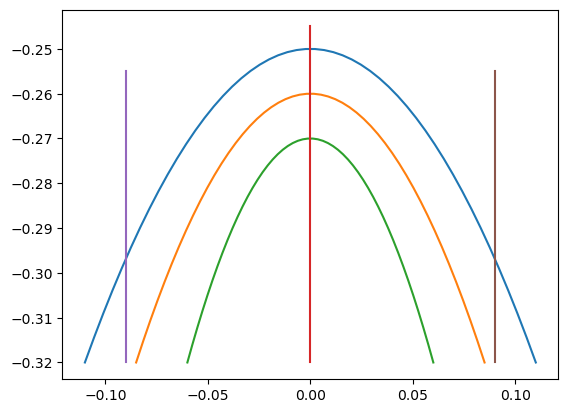

In [ ]:
for _, trajectory in problem.rewards_and_trajectories.trajectories.items():
    plt.plot(trajectory[:, 0], trajectory[:, 2])


plt.show()

In [ ]:
from auto_robot_design.pinokla.criterion_agregator import calculate_quasi_static_simdata
from pinocchio.visualize import MeshcatVisualizer
import meshcat
trajectory = problem.rewards_and_trajectories.trajectories[5]
x= np.round(X[7387],4)
graph = gm.get_graph(x)
fixed_robot, free_robot = jps_graph2pinocchio_robot(graph, builder=builder)
viz = MeshcatVisualizer(fixed_robot.model, fixed_robot.visual_model, fixed_robot.visual_model)
viz.viewer = meshcat.Visualizer().open()
viz.clean()
viz.loadViewerModel()
crag.get_criteria_data(fixed_robot, free_robot, trajectory,viz)
#calculate_quasi_static_simdata(free_robot, fixed_robot,'EE', trajectory, viz=viz)
pass

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7002/static/
